# Demo: CNN
Demostrate typical usages for debugging a Convolutional Neural Network

### Prepare pre-trained model

Using cache found in /Users/kaitoY/.cache/torch/hub/pytorch_vision_v0.10.0


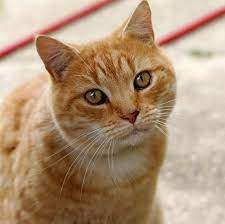

torch.Size([1000])
Egyptian cat 0.6638398170471191
tabby 0.19337327778339386
tiger cat 0.11212964355945587
lynx 0.024214286357164383
mouse 0.0006110002286732197


In [1]:
import torch
import torchvision
import os
from PIL import Image
from torchvision import transforms

model = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "resnet18",
    weights=torchvision.models.ResNet18_Weights.DEFAULT,
)
model.eval()
input_image = Image.open(os.path.join("..", "data", "cat.jpg"))
display(input_image)

preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = preprocess(input_image)
input_tensor_normed = norm(input_tensor)
input_batch = input_tensor_normed.unsqueeze(
    0
)  # create a mini-batch as expected by the model

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0].shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# Read the categories
with open(os.path.join("..", "data", "imagenet_classes.txt"), "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

### Visualize input gradients

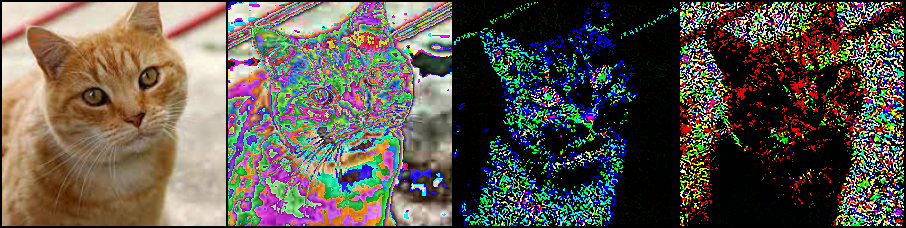

In [2]:
from diagnostics import get_gradients
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

# Use zero logits as baseline
baseline = torch.zeros((1, 1000))
target = torch.zeros((1, 1000))
# Use top1 class label as target
target[0][top5_catid[0]] = 1
gradients = get_gradients(model, input_batch, baseline, target)
# Visualizations
grad_pos = gradients[0].detach() * (gradients[0] > 0) * input_batch[0].detach()
grad_neg = gradients[0].detach() * (gradients[0] < 0) * input_batch[0].detach()
grid = make_grid([input_tensor.detach(), input_batch[0].detach(), grad_pos, grad_neg])
display(F.to_pil_image(grid))